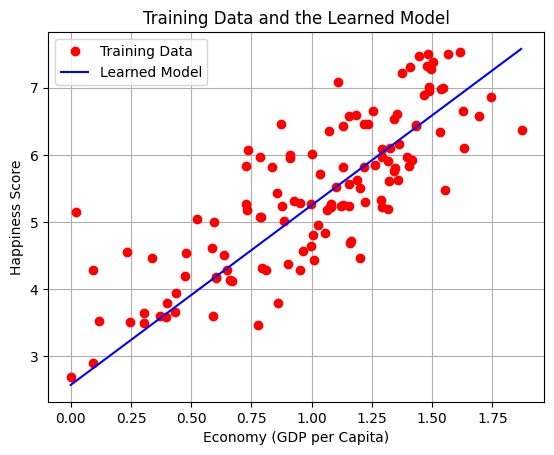

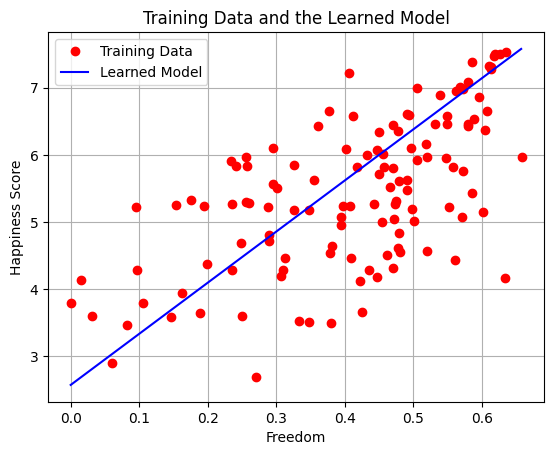

Learnt model: f(x) =  2.5738605174953464  +  1.7879392183924647  * x1 +  2.5264996951308634  * x2
Error (manual): 0.40385509403225794


In [1]:
import csv
import random
import matplotlib.pyplot as plt


def readDataFromCSV(file):
    data = []
    with open(file) as csvFile:
        reader = csv.reader(csvFile, delimiter=',')
        header = next(reader)
        for row in reader:
            dataRows = []
            for col in row[1:]:
                try:
                    dataRows.append(float(col))
                except ValueError:
                    dataRows.append(col)
            data.append(dataRows)
    return data, header[1:]


def prediction(x1, x2, beta0, beta1, beta2):
    return beta0 + beta1 * x1 + beta2 * x2


def MeanSquaredError(real, predicted):
    totalSquaredError = 0
    values = 0
    for realValue, predictedValue in zip(real, predicted):
        if realValue is not None and predictedValue is not None:
            totalSquaredError += (realValue - predictedValue) ** 2
            values += 1
    return totalSquaredError / values if values != 0 else float('inf')


def transpose(matrix):
    return [[matrix[j][i] for j in range(len(matrix))] for i in range(len(matrix[0]))]


def matrixMultiply(matrix1, matrix2):
    if len(matrix1[0]) != len(matrix2):
        raise ValueError("Matrices cannot be multiplied")
    result = [[0] * len(matrix2[0]) for _ in range(len(matrix1))]
    for i in range(len(matrix1)):
        for j in range(len(matrix2[0])):
            for k in range(len(matrix2)):
                result[i][j] += matrix1[i][k] * matrix2[k][j]
    return result


def matrixInverse(matrix):
    n = len(matrix)
    if n != len(matrix[0]):
        raise ValueError("Matrix is not square")
    identity = [[1 if i == j else 0 for j in range(n)] for i in range(n)]
    augmentedMatrix = [row + identity[i] for i, row in enumerate(matrix)]

    for col in range(n):
        for row in range(col + 1, n):
            if augmentedMatrix[row][col] != 0:
                multiplier = augmentedMatrix[col][col] / augmentedMatrix[row][col]
                augmentedMatrix[row] = [rowValue * multiplier - colValue for rowValue, colValue in
                                        zip(augmentedMatrix[row], augmentedMatrix[col])]

    for col in range(n - 1, -1, -1):
        if augmentedMatrix[col][col] == 0:
            raise ValueError("Singular matrix")
        multiplier = 1 / augmentedMatrix[col][col]
        augmentedMatrix[col] = [value * multiplier for value in augmentedMatrix[col]]
        for row in range(col - 1, -1, -1):
            multiplier = augmentedMatrix[row][col]
            augmentedMatrix[row] = [rowValue - colValue * multiplier for rowValue, colValue in
                                    zip(augmentedMatrix[row], augmentedMatrix[col])]

    inverse = [row[n:] for row in augmentedMatrix]
    return inverse


def manualRegression(x1, x2, y):
    X = [[1, el1, el2] for el1, el2 in zip(x1, x2)]
    X_T = transpose(X)
    X_T_X = matrixMultiply(X_T, X)
    X_T_X_inverse = matrixInverse(X_T_X)
    X_T_X_inverse_X_T = matrixMultiply(X_T_X_inverse, X_T)
    coefficients = matrixMultiply(X_T_X_inverse_X_T, [[el] for el in y])
    return [coef[0] for coef in coefficients]


# Read data
data, data_names = readDataFromCSV('v1_world-happiness-report-2017.csv')

inputName1 = 'Economy..GDP.per.Capita.'
inputName2 = 'Freedom'
outputName = 'Happiness.Score'

selected1 = data_names.index(inputName1)
selected2 = data_names.index(inputName2)
selectedOutput = data_names.index(outputName)

inputs1 = [row[selected1] for row in data]
inputs2 = [row[selected2] for row in data]
outputs = [row[selectedOutput] for row in data]

# Split data into training and validation sets
random.seed(1)
indexes = [i for i in range(len(inputs1))]
trainingSample = random.sample(indexes, int(0.8 * len(inputs1)))
validationSample = [i for i in indexes if i not in trainingSample]

trainInputs1 = [inputs1[i] for i in trainingSample]
trainInputs2 = [inputs2[i] for i in trainingSample]
trainOutputs = [outputs[i] for i in trainingSample]

validationInputs1 = [inputs1[i] for i in validationSample]
validationInputs2 = [inputs2[i] for i in validationSample]
validationOutputs = [outputs[i] for i in validationSample]

# Perform manual regression
coefficients = manualRegression(trainInputs1, trainInputs2, trainOutputs)

# Generate reference data for plotting
noOfPoints = 1000
xref1 = [min(trainInputs1) + i * (max(trainInputs1) - min(trainInputs1)) / noOfPoints for i in range(noOfPoints)]
xref2 = [min(trainInputs2) + i * (max(trainInputs2) - min(trainInputs2)) / noOfPoints for i in range(noOfPoints)]

yref = [coefficients[0] + coefficients[1] * x + coefficients[2] * z for x, z in zip(xref1, xref2)]

# Plot training data and the learned model
plt.plot(trainInputs1, trainOutputs, 'ro', label='Training Data')
plt.plot(xref1, yref, 'b-', label='Learned Model')
plt.title('Training Data and the Learned Model')
plt.xlabel('Economy (GDP per Capita)')
plt.ylabel('Happiness Score')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(trainInputs2, trainOutputs, 'ro', label='Training Data')
plt.plot(xref2, yref, 'b-', label='Learned Model')
plt.title('Training Data and the Learned Model')
plt.xlabel('Freedom')
plt.ylabel('Happiness Score')
plt.legend()
plt.grid(True)
plt.show()

print('Learnt model: f(x) = ', coefficients[0], ' + ', coefficients[1], ' * x1 + ', coefficients[2], ' * x2')

validationPrediction = [prediction(x1, x2, coefficients[0], coefficients[1], coefficients[2])
                        for x1, x2 in zip(validationInputs1, validationInputs2)]

error = MeanSquaredError(validationOutputs, validationPrediction)

print('Error (manual):', error)
